In [5]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'pytorch_practice/ants_and_bees/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
#%cd drive/My\ Drive/$FOLDERNAME/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd drive/My\ Drive/pytorch_practice/ants_and_bees/

/content/drive/My Drive/pytorch_practice/ants_and_bees


In [7]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [8]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)                     
    ]),                      
}

In [9]:
data_dir = 'hymenoptera_data'

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [14]:
def imshow(inp, title):
  inp = inp.numpy().transpose((1,2,0))
  inp = std*inp + mean
  inp = np.clip(inp, 0 , 1)
  plt.imshow(inp)
  plt.title(title)
  plt.show()

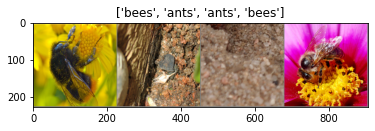

In [15]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])


In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
'''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs = 25)
'''
model_conv = models.resnet18(pretrained = True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 10, gamma = 0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 50)

Epoch 0/49
----------
train Loss: 0.6642 Acc: 0.7418
val Loss: 0.2520 Acc: 0.9085

Epoch 1/49
----------
train Loss: 1.0130 Acc: 0.7705
val Loss: 0.7280 Acc: 0.8301

Epoch 2/49
----------
train Loss: 0.9827 Acc: 0.7459
val Loss: 0.3656 Acc: 0.9085

Epoch 3/49
----------
train Loss: 1.3757 Acc: 0.7008
val Loss: 1.1918 Acc: 0.7451

Epoch 4/49
----------
train Loss: 1.0032 Acc: 0.7746
val Loss: 0.3244 Acc: 0.9477

Epoch 5/49
----------
train Loss: 0.7066 Acc: 0.7992
val Loss: 0.4790 Acc: 0.8562

Epoch 6/49
----------
train Loss: 0.9712 Acc: 0.7541
val Loss: 0.2726 Acc: 0.9477

Epoch 7/49
----------
train Loss: 0.9942 Acc: 0.7623
val Loss: 0.3180 Acc: 0.9412

Epoch 8/49
----------
train Loss: 0.9346 Acc: 0.7787
val Loss: 0.2992 Acc: 0.9346

Epoch 9/49
----------
train Loss: 0.6006 Acc: 0.8484
val Loss: 0.3777 Acc: 0.9150

Epoch 10/49
----------
train Loss: 0.4783 Acc: 0.8443
val Loss: 0.3070 Acc: 0.9020

Epoch 11/49
----------
train Loss: 0.5145 Acc: 0.8279
val Loss: 0.2856 Acc: 0.9412

Ep